In [1]:
#importando as dependencias necessarias
import pandas as pd
import json, csv
import numpy as np
#import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time, datetime, os
import sklearn
from sklearn import preprocessing, model_selection
from sklearn import tree
from sklearn2pmml.pipeline import PMMLPipeline
from nyoka import skl_to_pmml
import pickle
from sklearn.tree import export_text

In [2]:
#carregando o dataframe a partir do arquivo csv
df = pd.read_csv('data/satu.csv')
df.head()

,dateTime,battery,fileSize,sleepiness,pressure,lux,heartRate,ppgGreen,ppgRed,ppgIR,saturation,spo2Status,accelerometerZ,accelerometerX,accelerometerY,gyroscopeZ,gyroscopeX,gyroscopeY
0,2022-05-05T21:22:13-03:00,100.0,0.000216,0,1021.42970,16.0,0.0,0.0,6259838.0,7194523.0,0.0,0,6.569689,-1.096544,7.323863,-0.074526,-0.047647,-0.368963
1,2022-05-05T21:22:16-03:00,100.0,0.000372,0,1021.35060,4.0,0.0,1918012.0,6385203.0,7057272.0,0.0,0,2.583344,-9.423578,-4.836288,0.582765,-2.574186,0.436158
2,2022-05-05T21:22:19-03:00,100.0,0.000527,0,1021.49000,12.0,0.0,2116115.0,6299428.0,6819678.0,0.0,0,-10.625467,1.987187,0.852336,2.337170,1.080010,1.076345
3,2022-05-05T21:22:22-03:00,100.0,0.000680,0,1021.47095,12.0,137.0,2097705.0,5777941.0,6427349.0,0.0,0,-10.048465,-15.059528,6.347029,-2.566856,0.748921,-0.305433
4,2022-05-05T21:22:25-03:00,100.0,0.000841,0,1021.55130,0.0,139.0,2009880.0,6079344.0,6976056.0,0.0,0,-8.391677,-1.541866,4.783615,-0.283441,0.375071,-0.723264


In [3]:
#convertendo datetime para valor numerico
if(df.dateTime.isnull()[0]):
    df = df.iloc[1: , :]
    df = df.reset_index()
time = []
df.head() 
y, mo, d = map(int, str(df['dateTime'][0])[0:10].split('-'))
h,m,s = map(int, str(df['dateTime'][0])[11:19].split(':'))
startingTime = datetime.datetime(y, mo, d, h, m, s).timestamp()

for val in range(len(df.dateTime)):
    v = str(df.dateTime[val])
    y, mo, d = map(int, v[0:10].split('-'))
    h,m,s = map(int, v[11:19].split(':'))
    ts = datetime.datetime(y, mo, d, h, m, s).timestamp()
    ts = ts - startingTime
    time.append(ts)
    
df.drop('dateTime', axis = 1, inplace=True)
df['dateTime'] = time
df.head()

,battery,fileSize,sleepiness,pressure,lux,heartRate,ppgGreen,ppgRed,ppgIR,saturation,spo2Status,accelerometerZ,accelerometerX,accelerometerY,gyroscopeZ,gyroscopeX,gyroscopeY,dateTime
0,100.0,0.000216,0,1021.42970,16.0,0.0,0.0,6259838.0,7194523.0,0.0,0,6.569689,-1.096544,7.323863,-0.074526,-0.047647,-0.368963,0.0
1,100.0,0.000372,0,1021.35060,4.0,0.0,1918012.0,6385203.0,7057272.0,0.0,0,2.583344,-9.423578,-4.836288,0.582765,-2.574186,0.436158,3.0
2,100.0,0.000527,0,1021.49000,12.0,0.0,2116115.0,6299428.0,6819678.0,0.0,0,-10.625467,1.987187,0.852336,2.337170,1.080010,1.076345,6.0
3,100.0,0.000680,0,1021.47095,12.0,137.0,2097705.0,5777941.0,6427349.0,0.0,0,-10.048465,-15.059528,6.347029,-2.566856,0.748921,-0.305433,9.0
4,100.0,0.000841,0,1021.55130,0.0,139.0,2009880.0,6079344.0,6976056.0,0.0,0,-8.391677,-1.541866,4.783615,-0.283441,0.375071,-0.723264,12.0


In [4]:
#data = df[["dateTime", "heartRate", "ppgGreen", "ppgRed", "ppgIR", "saturation","sleepiness"]]
data = df[["dateTime", "heartRate", "ppgGreen", "ppgRed", "ppgIR", "saturation","sleepiness", "pressure", "accelerometerX", "accelerometerY", "accelerometerZ", "gyroscopeX", "gyroscopeY", "gyroscopeZ"]]
data.head()

,dateTime,heartRate,ppgGreen,ppgRed,ppgIR,saturation,sleepiness,pressure,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ
0,0.0,0.0,0.0,6259838.0,7194523.0,0.0,0,1021.42970,-1.096544,7.323863,6.569689,-0.047647,-0.368963,-0.074526
1,3.0,0.0,1918012.0,6385203.0,7057272.0,0.0,0,1021.35060,-9.423578,-4.836288,2.583344,-2.574186,0.436158,0.582765
2,6.0,0.0,2116115.0,6299428.0,6819678.0,0.0,0,1021.49000,1.987187,0.852336,-10.625467,1.080010,1.076345,2.337170
3,9.0,137.0,2097705.0,5777941.0,6427349.0,0.0,0,1021.47095,-15.059528,6.347029,-10.048465,0.748921,-0.305433,-2.566856
4,12.0,139.0,2009880.0,6079344.0,6976056.0,0.0,0,1021.55130,-1.541866,4.783615,-8.391677,0.375071,-0.723264,-0.283441


C:\Users\lapto\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


dateTime            0
heartRate          15
ppgGreen            2
ppgRed              0
ppgIR               0
saturation        382
sleepiness          0
pressure            0
accelerometerX      0
accelerometerY      0
accelerometerZ      0
gyroscopeX          0
gyroscopeY          0
gyroscopeZ          0
dtype: int64

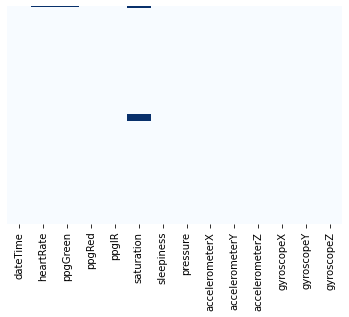

In [5]:
#verificando se existem dados faltando
data.ppgGreen.replace(0, np.nan, inplace=True)
data.ppgRed.replace(0, np.nan, inplace=True)
data.heartRate.replace(0, np.nan, inplace=True)
data.ppgIR.replace(0, np.nan, inplace=True)
data.saturation.replace(0, np.nan, inplace=True)
hm = sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'Blues')
data.isna().sum()

In [6]:
#substituindo os valores faltantes pela media da coluna (caso nao existam nao e necessario executar essa celula)
#obs: apenas valido para valores numericos
num_col = ['heartRate', 'ppgGreen', "saturation"] # lista com as colunas que possuem valores faltantes
for col in num_col:
    data[col]=pd.to_numeric(data[col])
    data[col].fillna(data[col].mean(), inplace=True)
data.isna().sum()

C:\Users\lapto\AppData\Local\Temp\ipykernel_9576\416091374.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col]=pd.to_numeric(data[col])
C:\Users\lapto\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


dateTime          0
heartRate         0
ppgGreen          0
ppgRed            0
ppgIR             0
saturation        0
sleepiness        0
pressure          0
accelerometerX    0
accelerometerY    0
accelerometerZ    0
gyroscopeX        0
gyroscopeY        0
gyroscopeZ        0
dtype: int64

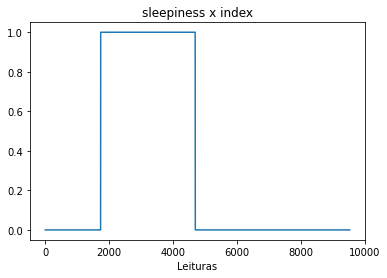

In [7]:
#visualizando as leituras de cada variavel
items = ['sleepiness'] #'pressure', 'lux', 'heartRate', 'ppgGreen', 'ppgRed', 'ppgIR', 'saturation', 'accelerometerZ', 'accelerometerX','accelerometerY', 'gyroscopeZ', 'gyroscopeX', 'gyroscopeY', 
for var in items:
    y = df[var]
    #x = range(5000)
    x = range(y.size)
    plt.figure()
    plt.title(f"{var} x index")
    plt.xlabel("Leituras")
    #plt.ylabel(f"{units[var]}")
    plt.plot(x,y)
    plt.savefig(f'graphs/linePlot_{y.name}.png', bbox_inches='tight')

In [8]:
#teste de predicao por svm sem pre-processamento dos dados

le = preprocessing.LabelEncoder()
label = "sleepiness"

x = np.array(data.drop([label, 'dateTime'], 1))
y = np.array(data[label])
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.3)

model = tree.DecisionTreeClassifier()
model.fit(x_train, y_train)

acc = model.score(x_test, y_test)
predicted = model.predict(x_test)

with open("predicoes/decTree.txt", "w") as outFile:

    for i in range(len(predicted)):
        outFile.write(f"Predito: {predicted[i]} - Dados: {x_test[i]} - Real: {y_test[i]}\n")
        
    outFile.write(f"\nProcesso finalizado com acurácia de {float(acc)*100}%")
    
print(float(acc)*100)

C:\Users\lapto\AppData\Local\Temp\ipykernel_9576\2126988403.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = np.array(data.drop([label, 'dateTime'], 1))


98.98636840265641


In [9]:
# salvando o modelo em formato pickle (para API)
with open("models/decTree_model.pickle", "wb") as file:
    pickle.dump(model, file)

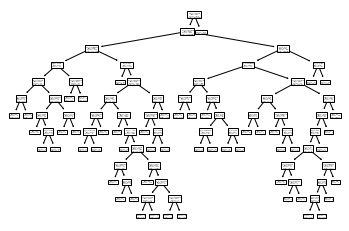

In [10]:
tree.plot_tree(model)
plt.savefig(f'graphs/decisionTree.png', bbox_inches='tight')

In [12]:
features = list(data.columns)
features.remove("sleepiness")
features.remove("dateTime")
tree_rules = export_text(model, feature_names=features)
with open("models/decision_path.txt", "w") as file:
    file.write(tree_rules)

Balanced Acc: 0.9898218961300533
Recall Score: 0.9897142857142858


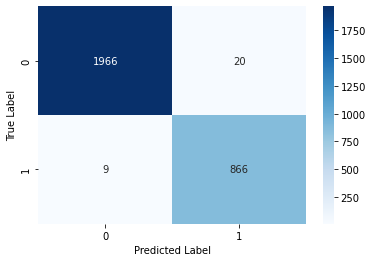

In [14]:
# avaliando metricas do modelo
from sklearn.metrics import balanced_accuracy_score, recall_score, confusion_matrix
print(f"Balanced Acc: {balanced_accuracy_score(y_test, predicted)}")
print(f"Recall Score: {recall_score(y_test, predicted)}")
"""fig = plot_confusion_matrix(model, x_test, y_test)
plt.savefig(f'graphs/decTree_confusion_matrix.png', bbox_inches='tight')
plt.show()"""
cm = confusion_matrix(y_test, predicted)
hm = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
hm.set(xlabel='Predicted Label', ylabel='True Label')
figure = hm.get_figure()
figure.savefig('graphs/decTree_confusion_matrix.png', bbox_inches='tight', dpi=800)